# Urbanization Index Comparisons with Global Human Settlement (GHS)

* **Products used:** 
[gm_ls8_annual](https://explorer.digitalearth.africa/gm_ls8_annual), 
[wofs_ls_summary_alltime](https://explorer.digitalearth.africa/wofs_ls_summary_alltime)

## Background
There are many different urbanization indices with different characteristics and use cases. It is often convenient to be able to compare the performance of several  indicies for an area - determining which is the best for an area based on the outputs and a "ground truth" dataset of urbanization.

## Description

This notebook uses several indices to classify land as "urban" and then compares those results with the [Global Human Settlement (GHS) product](https://ghsl.jrc.ec.europa.eu/ghs_bu2019.php) which shows the extent of built-up area (urban extent) through to 2014. The indices tested here are the  **Normalized Difference Buildup Index (NDBI)**, the **Enhanced Normalized Difference Impervious Surface Index (ENDISI)** and the **Artificial Surface Index (ASI)**. 

1. Load a geomedian image from the region of interest.
2. Mask water using the WOfS All Time Summary
3. Calulate urban indices and show histograms for the indices.
4. Select minimum and maximum threshold values for the indicies to determine urban pixels.
5. Show the urbanization prediction images.
6. Load and show the "ground truth" data (GHS) for the year 2014.
7. Compare the urbanization predictions with the "ground truth" data visually and statistically.

The choice of threshold values can be informed by the histograms and comparing the urbanization prediction images with the "ground truth" urbanization data.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import numpy as np
import geopandas as gpd
import rioxarray
from collections import namedtuple
from odc.geo.geom import Geometry
from skimage.morphology import remove_small_objects
from skimage.morphology import remove_small_holes
from matplotlib.patches import Patch
from odc.algo import xr_reproject

from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.areaofinterest import define_area

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app="Urbanization_GHS_Comparison")

### Analysis parameters

The following cell sets important parameters for the analysis. The parameters are:

* `lat`: The central latitude to analyse (e.g. `10.338`).
* `lon`: The central longitude to analyse (e.g. `-1.055`).
* `lat_buffer`: The number of degrees to load around the central latitude.
* `lon_buffer`: The number of degrees to load around the central longitude.
* `time_range`: The time range to analyze - in YYYY-MM-DD format (e.g. `('2016-01-01', '2016-12-31')`).


#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

    Alternatively, you can provide separate buffer values for latitude and longitude for a rectangular area. For example, `lat = 10.338`, `lon = -1.055`, and `lat_buffer = 0.1` and`lon_buffer = 0.08` will select a rectangular area extending 0.1 degrees north and south, and 0.08 degrees east and west from the point `(10.338, -1.055)`.

   For reasonable loading times, set the buffer as `0.1` or lower.

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

**If running the notebook for the first time**, keep the default settings below.
The default area is Dakar, Senegal.

In [3]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat= 14.72, lon=-17.355, buffer=0.2)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
# aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

time_range = ("2017")

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
# The code below renders a map that can be used to view the region.
display_map(lon_range, lat_range)

## Load the Landsat 8 Annual GeoMAD

We will load the Landsat 8 Annual GeoMAD from 2017.

In [5]:
# Create the 'query' dictionary object.
query = {
    "longitude": lon_range,
    "latitude": lat_range,
    "time": time_range,
    "resolution": (-20, 20),
}

# Load the geomedian.
ds = dc.load(product='gm_ls8_annual',
             measurements=["red", "green", "blue", "swir_1", "swir_2", "nir"],
             **query
            ).squeeze()


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` attribute revels the number of time steps in the data set, as well as the number of pixels in the `longitude` and `latitude` dimensions.

In [6]:
ds

<xarray.Dataset> Size: 57MB
Dimensions:      (y: 2471, x: 1930)
Coordinates:
    time         datetime64[ns] 8B 2017-07-02T11:59:59.999999
  * y            (y) float64 20kB 1.883e+06 1.882e+06 ... 1.833e+06 1.833e+06
  * x            (x) float64 15kB -1.694e+06 -1.694e+06 ... -1.655e+06
    spatial_ref  int32 4B 6933
Data variables:
    red          (y, x) uint16 10MB 190 207 209 209 205 ... 180 180 190 185 185
    green        (y, x) uint16 10MB 232 245 249 249 245 ... 275 275 282 277 277
    blue         (y, x) uint16 10MB 106 108 105 105 128 ... 138 138 136 131 131
    swir_1       (y, x) uint16 10MB 238 270 277 277 261 ... 256 256 273 265 265
    swir_2       (y, x) uint16 10MB 221 241 245 245 231 ... 228 228 241 237 237
    nir          (y, x) uint16 10MB 210 223 226 226 216 ... 202 202 211 203 203
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

### Clip the datasets to the shape of the area of interest
A geopolygon represents the bounds and not the actual shape because it is designed to represent the extent of the geographic feature being mapped, rather than the exact shape. In other words, the geopolygon is used to define the outer boundary of the area of interest, rather than the internal features and characteristics.

Clipping the data to the exact shape of the area of interest is important because it helps ensure that the data being used is relevant to the specific study area of interest. While a geopolygon provides information about the boundary of the geographic feature being represented, it does not necessarily reflect the exact shape or extent of the area of interest.

In [7]:
#Rasterise the area of interest polygon
aoi_raster = xr_rasterize(gdf=geopolygon_gdf, da=ds, crs=ds.crs)
#Mask the dataset to the rasterised area of interest
ds = ds.where(aoi_raster == 1)

### Filter out water pixels using WOfS

In [8]:
# Create a water mask using WOfS.
water = dc.load(
    product="wofs_ls_summary_alltime",
    like=ds.geobox).frequency

# Mask out water.
water_mask = water > 0.1
ds = ds.where(~water_mask.squeeze())

## Land Spectral Indices

We're going to be calculating NDBI, ENDISI and ASI as urbanization indices.

> ### NDBI
The Normalized Difference Built-Up Index (NDBI) is one of the most commonly used proxies of urbanization. Like all normalized difference indicies, it has a range of \[-1,1\].

$$
\begin{aligned}
\text{NDBI} = \frac{\text{SWIR1} - \text{NIR}}{\text{SWIR1} + \text{NIR}}
\end{aligned}
$$

> ### ENDISI
The Enhanced Normalized Difference Impervious Surfaces Index (ENDISI) is a more recently developed urbanization proxy. Like all normalized difference indicies, it has a range of \[-1,1\].
Note that `MNDWI`, `swir_diff` and `alpha` are all part of the ENDISI calculation.

$$
\begin{aligned}
\text{MNDWI} = \frac{\text{GREEN} - \text{SWIR1}}{\text{GREEN} + \text{SWIR1}}
\end{aligned}
$$

$$
\begin{aligned}
{swir_diff} = \frac{{SWIR1}}{\text{SWIR2}}
\end{aligned}
$$

$$
\begin{aligned}
{alpha} = \frac{{2*mean(BLUE)}}{{mean(swir_diff) + mean(MNDWI^2)}}
\end{aligned}
$$

$$
\begin{aligned}
{ENDISI} = \frac{{BLUE} - {alpha}*({swir_diff} + {MNDWI^2})}
{{BLUE} + {alpha}*({swir_diff} + {MNDWI^2})}
\end{aligned}
$$

> ### ASI
The Artificial Surface Index (ASI) has a range of \[0, 1\] . ASI is composed of four components: 
    

1. The Artificial Surface Factor (AF):

\begin{aligned}
  AF = \frac{NIR - BLUE}{NIR + BLUE}
\end{aligned}

2. The Vegetation Suppressing Factor (VSF) which is includes the Normalized Difference Vegetation Index and the Modified Soil Adjusted Vegetation Index.

\begin{aligned}
  NDVI = \frac{NIR - RED}{NIR + RED}
\end{aligned}

\begin{aligned}
  MSAVI = \frac{2*NIR + 1 - \sqrt{(2*NIR + 1)^2 − 8*(NIR - RED)}}{2}
\end{aligned}

\begin{aligned}
  VSF = 1 − NDVI * MSAVI
\end{aligned}

3. Soil Suppressing Factor (SSF) which includes the Modified Bare soil Index (MBI), Modified Normalized Difference Water Index (MNDWI), and Enhanced Modified Bare soil Index (EMBI).

\begin{aligned}
  MBI = \frac{SWIR1 - SWIR2 - NIR}{SWIR1 + SWIR2 + NIR} + 0.5
\end{aligned}

$$
\begin{aligned}
\text{MNDWI} = \frac{\text{GREEN} - \text{SWIR1}}{\text{GREEN} + \text{SWIR1}}
\end{aligned}
$$

$$
\begin{aligned}
\text{EMBI} = \frac{MBI - MNDWI - 0.5}{MBI + MNDWI + 1.5}
\end{aligned}
$$

$$
\begin{aligned}
\text{SSF} = 1 - EMBI
\end{aligned}
$$

4. Modulation Factor (MF) 

$$
\begin{aligned}
\text{MF} = \frac{(BLUE + GREEN) - (NIR + SWIR1)}{(BLUE + GREEN) + (NIR + SWIR1)}
\end{aligned}
$$

The Artificial Surface Index (ASI) is finalized as:

\begin{equation}
ASI = f(AF) × f(VSF) × f(SSF) × f(MF)
\end{equation}

$f$ means the min–max normalization function based on the entire image, i.e., $y = (x − x_{min})/(x_{max} − x_{min})$

### Calculate NDBI, ENDISI and ASI

In [9]:
# NDBI, ENDISI and ASI using DE Africa funciton calculate_indices.
ds = calculate_indices(ds, index=['NDBI', "ENDISI", "ASI"], satellite_mission='ls')

### Plot the urban indices

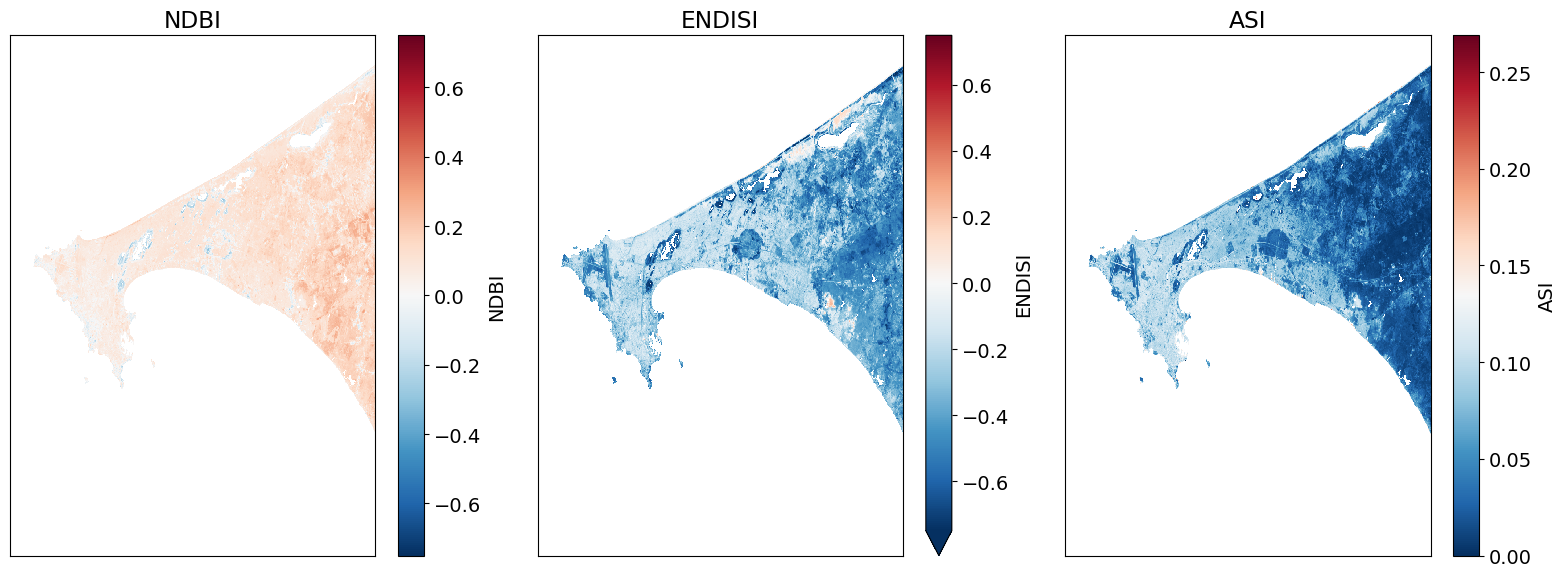

In [10]:
# Plot.
fig, ax = plt.subplots(1, 3, figsize=(16,6), sharey=True)
ds.NDBI.plot.imshow(ax=ax[0], vmin=-.75, vmax=.75, cmap='RdBu_r')
ds.ENDISI.plot.imshow(ax=ax[1], vmin=-.75, vmax=.75, cmap='RdBu_r')
ds.ASI.plot.imshow(ax=ax[2], cmap='RdBu_r')

ax[0].set_title('NDBI'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('ENDISI'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
ax[2].set_title('ASI'), ax[2].xaxis.set_visible(False), ax[2].yaxis.set_visible(False)

plt.tight_layout();

## Determining the thresholds for urbanization
These histogram plots show the distribution of values for each product.
The urban threshold values are chosen using these histograms.

If a highly urban area is being examined, there should be visible maximal values for these histograms. The ideal thresholds should usually include these values (see the x axes of the histograms) and some range of values less than and greater than these maximal values.

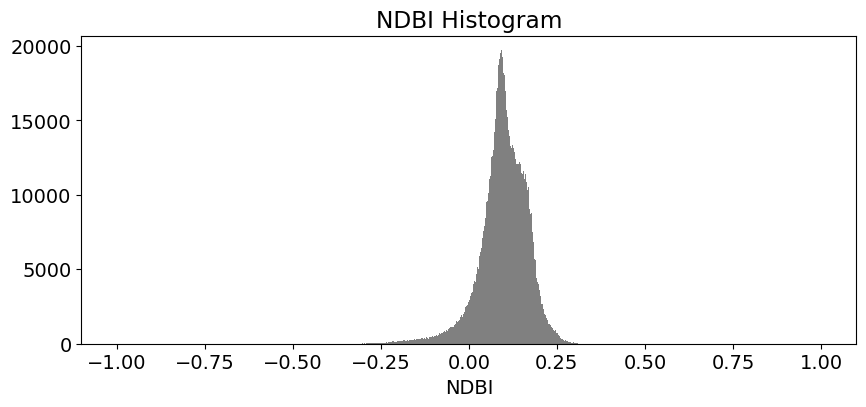

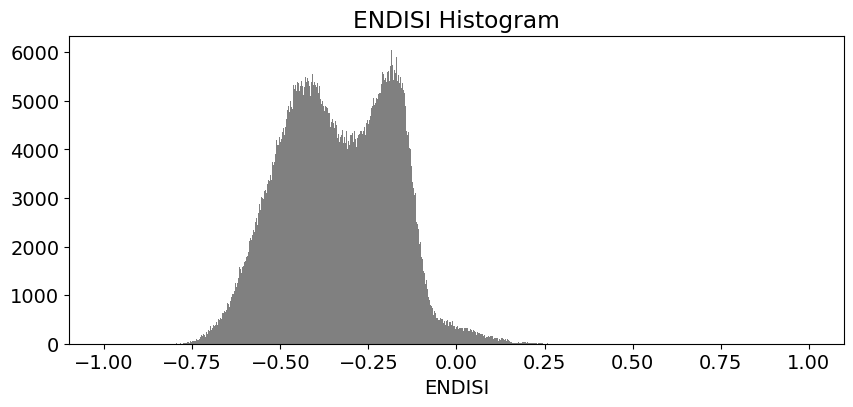

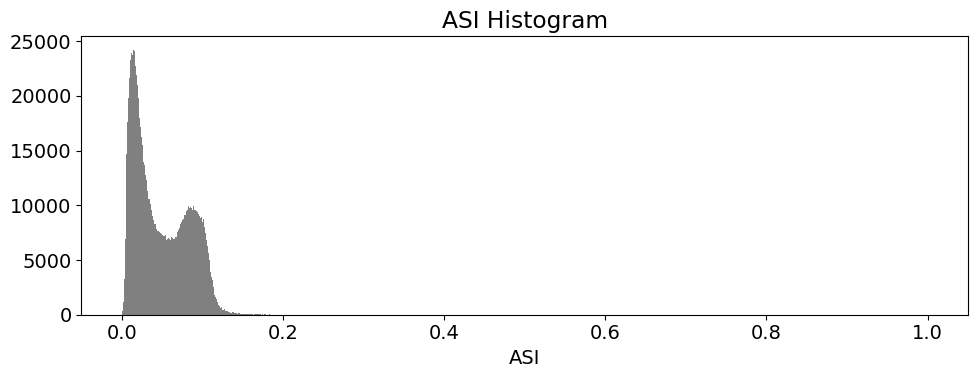

In [11]:
# NDBI
ds.NDBI.plot.hist(bins=1000, range=(-1,1), facecolor='gray', figsize=(10, 4))
plt.title('NDBI Histogram')

# ENDISI
ds.ENDISI.plot.hist(bins=1000, range=(-1,1), facecolor='gray', figsize=(10, 4))
plt.title('ENDISI Histogram')

# ASI
ds.ASI.plot.hist(bins=1000, range=(0,1), facecolor='gray', figsize=(10, 4))
plt.title('ASI Histogram')

plt.tight_layout();

## Create Threshold Plots
First we will define a minimum threshold and a maximum threshold for each index. Then we will create plots that color the threshold region a single color (e.g. red).

In [12]:
# NDBI = -1.0 to 1.0 (full range)
# NDBI -0.1 to 0.3 is typical for urban areas
min_ndbi_threshold = -0.1
max_ndbi_threshold = 0.15

# ENDISI = -1.0 to 1.0 (full range)
# ENDISI -0.2 to 0.4 is typical for urban areas
min_endisi_threshold = -0.3
max_endisi_threshold = 0.1

# ASI = 0 to 1.0 (full range)
# ASI -0.05 to 1 is typical for urban areas
min_asi_threshold = 0.05
max_asi_threshold = 1 #0.1

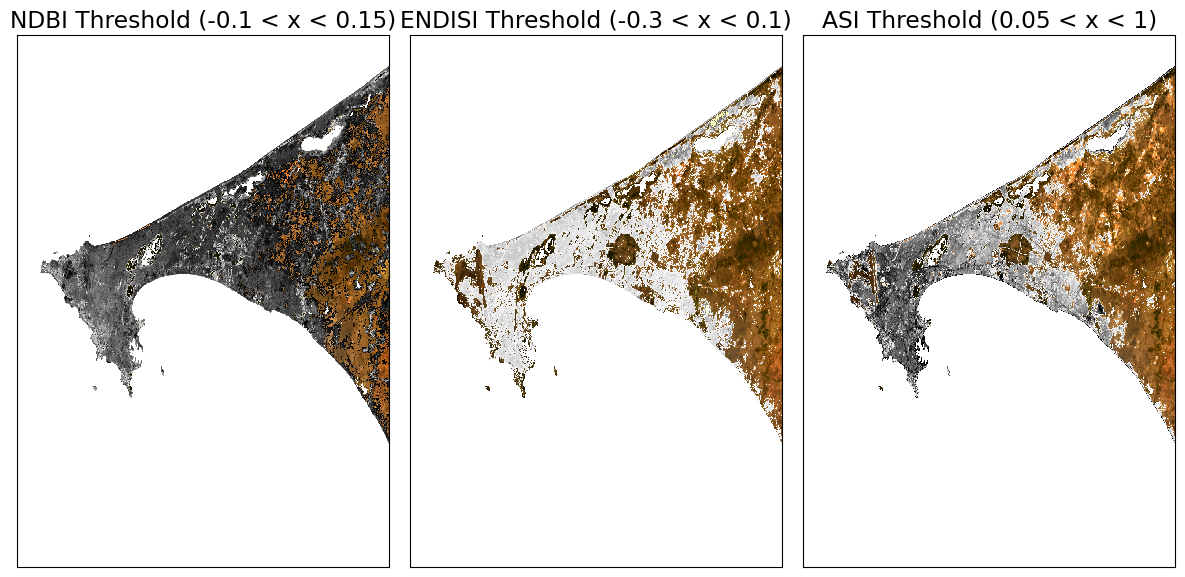

In [13]:
# Set up the sub-plots.
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

rgb(ds, ax=ax[0])
ds.NDBI.where((ds.NDBI > min_ndbi_threshold) &
                          (ds.NDBI < max_ndbi_threshold)).plot.imshow(
                              cmap='Greys',
                              ax=ax[0],
                              robust=True,
                              add_colorbar=False,
                              add_labels=False)

rgb(ds, ax=ax[1])
ds.ENDISI.where((ds.ENDISI > min_endisi_threshold) &
                            (ds.ENDISI < max_endisi_threshold)).plot.imshow(
                                  cmap='Greys',
                                  ax=ax[1],
                                  robust=True, 
                                  add_colorbar=False,
                                  add_labels=False)

rgb(ds, ax=ax[2])
ds.ASI.where((ds.ASI > min_asi_threshold) &
                            (ds.ASI < max_asi_threshold)).plot.imshow(
                                  cmap='Greys',
                                  ax=ax[2],
                                  robust=True, 
                                  add_colorbar=False,
                                  add_labels=False)

# Remove axes plotting elements.
for a in ax:
    a.xaxis.set_visible(False)
    a.yaxis.set_visible(False)

# Set titles.
ax[0].set_title(f'NDBI Threshold ({min_ndbi_threshold} < x < {max_ndbi_threshold})')
ax[1].set_title(f'ENDISI Threshold ({min_endisi_threshold} < x < {max_endisi_threshold})')
ax[2].set_title(f'ASI Threshold ({min_asi_threshold} < x < {max_asi_threshold})')

plt.tight_layout();

## Comparison Metrics
We will compare the performance of the urban index results against the GHS GeoTIFF product (shown below).

The GHS geotiff for the Senegal region is available by default in the `Supplementary_data` folder. To find and download GHS geotiffs for other regions, use the following link: https://ghsl.jrc.ec.europa.eu/download.php?ds=bu


In [14]:
# Senegal region.
tif = '../Supplementary_data/Urban_index_comparison/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_12_10.tif'

### Open and reproject dataset to match Landsat

In [15]:
# Open
ghs_ds = rioxarray.open_rasterio(tif).squeeze().chunk({'x':5000, 'y':5000})

# Reproject to match our landsat composite.
ghs_ds = xr_reproject(ghs_ds,
             ds.geobox,"nearest").compute()

# Threshold GHS to get all the urban areas.
actual = (ghs_ds >= 3) & (ghs_ds <= 6)

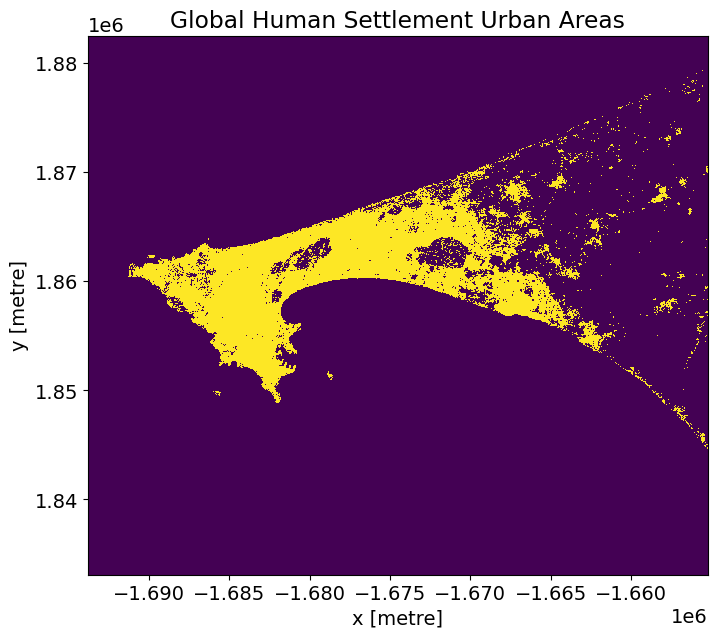

In [16]:
# Plot.
actual.plot(figsize=(8,7), add_colorbar=False)
plt.title('Global Human Settlement Urban Areas');

## Metric and Plotting Functions
The code below will calculate the true/false positive/negative sums and calculate values for a typical confusion matrix to assess the results. Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. 

$$
\begin{aligned}
\text{Accuracy} = \frac{\text{True Positive} + \text{True Negative}}{\text{Total Pixels}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}
\end{aligned}
$$

$$
\begin{aligned}
\text{F1 Score} = 2*\frac{\text{Recall}*\text{Precision}}{\text{Recall} + \text{Precision}}
\end{aligned}
$$

In [17]:
def get_metrics(actual, predicted, minimum_threshold, maximum_threshold, filter_size=1):
    """ Creates performance metrics.
    
    Args:
        actual: the data to use as truth.
        predicted: the data to predict and to compare against actual.
        minimum_threshold: the minimum threshold to apply on the predicted values for generating a boolean mask.
        maximum_threshold: the maximum threshold to apply on the predicted values for generating a boolean mask.
        filter_size: the filter size to apply on predicted to remove small object/holes with.
        
    Returns: A namedtuple containing the actual, predicted mask, and varying metrics for a confusion matrix.
    """
    metrics = namedtuple('Metrics',
                         'actual predicted true_positive true_negative false_positive false_negative')

    predicted  = (predicted > minimum_threshold) & (predicted < maximum_threshold)
    predicted  = remove_small_objects(predicted, min_size=filter_size+1, connectivity=2)
    predicted  = remove_small_holes(predicted, area_threshold=filter_size+1, connectivity=2)

    true_positive=(predicted & actual).sum()
    true_negative=(~predicted & ~actual).sum()
    false_positive=(predicted & ~actual).sum()
    false_negative=(~predicted & actual).sum()

    return metrics(actual=actual,
                   predicted=predicted,
                   true_positive=true_positive,
                   true_negative=true_negative,
                   false_positive=false_positive,
                   false_negative=false_negative)

def print_metrics(metrics):
    norm = metrics.true_positive + metrics.false_negative + metrics.false_positive + metrics.true_negative
    accuracy = (metrics.true_positive + metrics.true_negative)/norm
    ppv = metrics.true_positive/(metrics.true_positive + metrics.false_positive)
    tpr = metrics.true_positive/(metrics.true_positive + metrics.false_negative)
    f1 = (2*ppv*tpr)/(ppv+tpr)
    
    print('True Positive (Actual + Model = Urban): {tp}'.format(tp=round(metrics.true_positive/norm*100,3)))
    print('True Negative (Actual + Model = Non-Urban): {tn}'.format(tn=round(metrics.true_negative/norm*100,3)))
    print('False Positive (Actual=Non-Urban, Model=Urban): {fp}'.format(fp=round(metrics.false_positive/norm*100,3)))
    print('False Negative (Actual=Urban, Model=Non-Urban): {fn}'.format(fn=round(metrics.false_negative/norm*100,3)))
    print('\nAccuracy: {accuracy}'.format(accuracy=round(accuracy*100, 3)))
    print('F1 Score: {f1}\n'.format(f1=round(f1*100, 3)))

In [18]:
indexes =['NDBI','ENDISI', 'ASI']
min_thresholds = [min_ndbi_threshold, min_endisi_threshold, min_asi_threshold] 
max_thresholds =[max_ndbi_threshold, max_endisi_threshold, max_asi_threshold]

index_metrics=[]
for index, min_thresh, max_thresh in zip(indexes, min_thresholds, max_thresholds):
    print ('\033[1m' + '\033[91m' + index+' - Comparison Results') # bold print and red
    print ('\033[0m') # stop bold and red
    metrics = get_metrics(actual.values, ds[index].values, min_thresh, max_thresh)
    index_metrics.append(metrics)
    print_metrics(metrics)

#create a dictionary with the accuracy data in it
index_metrics = {indexes[i]: index_metrics[i] for i in range(len(indexes))}

NDBI - Comparison Results

True Positive (Actual + Model = Urban): 9.433
True Negative (Actual + Model = Non-Urban): 80.572
False Positive (Actual=Non-Urban, Model=Urban): 9.735
False Negative (Actual=Urban, Model=Non-Urban): 0.26

Accuracy: 90.005
F1 Score: 65.367

ENDISI - Comparison Results

True Positive (Actual + Model = Urban): 7.267
True Negative (Actual + Model = Non-Urban): 86.918
False Positive (Actual=Non-Urban, Model=Urban): 3.389
False Negative (Actual=Urban, Model=Non-Urban): 2.426

Accuracy: 94.185
F1 Score: 71.422

ASI - Comparison Results

True Positive (Actual + Model = Urban): 8.463
True Negative (Actual + Model = Non-Urban): 87.891
False Positive (Actual=Non-Urban, Model=Urban): 2.416
False Negative (Actual=Urban, Model=Non-Urban): 1.23

Accuracy: 96.354
F1 Score: 82.276



## Output Comparisons
The `dstack` calls provide the `imshow` calls with RGB array inputs. For each image, the first channel (red) is the actual (ground truth, GHS) values, and both the second and third channels (green, blue) are the predicted values (green + blue = cyan).

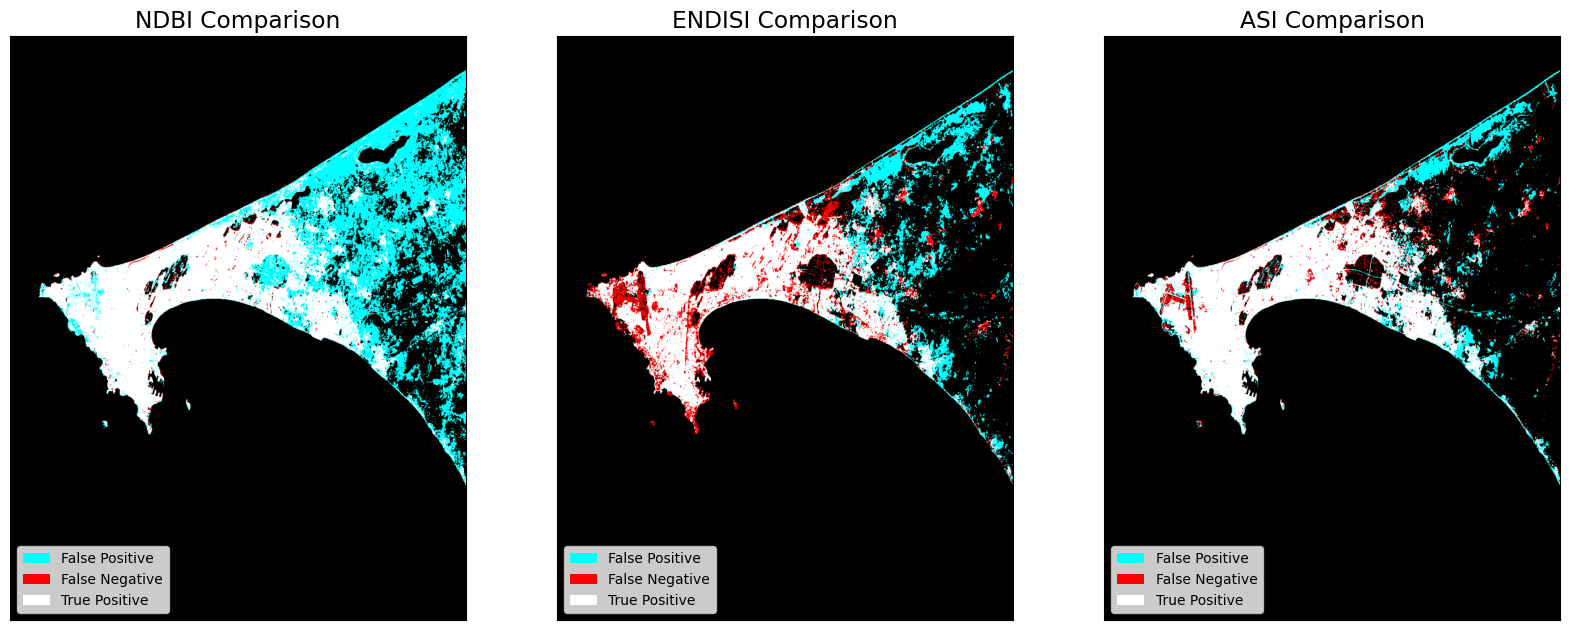

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(20,10))

for a, key in zip(ax, index_metrics):
    a.imshow(np.dstack((index_metrics[key].actual.astype(float),
                        index_metrics[key].predicted.astype(float),
                        index_metrics[key].predicted.astype(float))))
    a.legend(
        [Patch(facecolor='cyan'), Patch(facecolor='red'), Patch(facecolor='white')], 
        ['False Positive', 'False Negative', 'True Positive'], loc='lower left', fontsize=10)
    a.xaxis.set_visible(False)
    a.yaxis.set_visible(False)
    a.set_title(key +' Comparison')

## Next Steps
Machine learning can also be used to measure urbanisation. See [this notebook](../Real_world_examples/Machine_learning_with_ODC.ipynb) for a guide on using machine learning in the context of the ODC.

---

## Additional information

<b> License </b> The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).

Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

<b> Contact </b> If you need assistance, please post a question on the [DE Africa Slack channel](https://digitalearthafrica.slack.com/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

<b> Compatible datacube version </b>

In [20]:
print(datacube.__version__)

1.8.20


**Last Tested:**

In [21]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-01-16'